In [1]:
# Imports and settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
sns.set(style='whitegrid')

# --------------------------------------
# Step 1: Load dataset (cleaned version)
# --------------------------------------
csv_name = 'house_price_cleaned.csv'
if os.path.exists(csv_name):
    df = pd.read_csv(csv_name)
    print(f"Loaded '{csv_name}' (shape: {df.shape})")
else:
    print(f"'{csv_name}' not found — creating a sample dataset for clustering.")
    data = {
        'HouseID': list(range(1, 51)),
        'Area': np.concatenate([np.random.normal(100, 30, 40), np.random.normal(250, 50, 10)]).tolist(),
        'Rooms': np.random.randint(2, 8, size=50).tolist(),
        'Price': np.concatenate([np.random.normal(200000, 50000, 40), np.random.normal(500000, 80000, 10)]).tolist()
    }
    df = pd.DataFrame(data)
    df.to_csv(csv_name, index=False)
    print(f"Sample '{csv_name}' created (shape: {df.shape})")

df.head()


'house_price_cleaned.csv' not found — creating a sample dataset for clustering.
Sample 'house_price_cleaned.csv' created (shape: (50, 4))


,HouseID,Area,Rooms,Price
0,1,66.838172,5,131570.486492
1,2,82.639692,3,179549.540389
2,3,111.950883,6,138646.585196
3,4,105.595128,5,172803.525014
4,5,159.827880,3,162073.007593


In [2]:
# Select numeric columns (exclude identifiers)
numeric = df.select_dtypes(include=[np.number]).copy()
if 'HouseID' in numeric.columns:
    numeric = numeric.drop(columns=['HouseID'])

print("Numeric columns used for clustering:", list(numeric.columns))

# Fill missing values with median
numeric = numeric.fillna(numeric.median())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric)

print("Scaled feature matrix shape:", X_scaled.shape)


Numeric columns used for clustering: ['Area', 'Rooms', 'Price']
Scaled feature matrix shape: (50, 3)


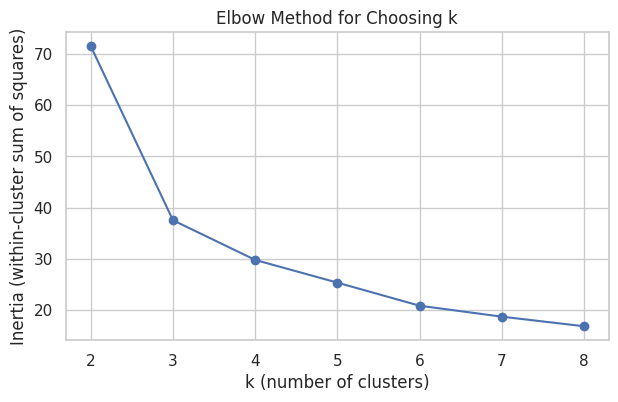

Inertias: {2: 71.54563442506057, 3: 37.53532809795523, 4: 29.779132579332444, 5: 25.344001750214314, 6: 20.833103845373092, 7: 18.692184935456382, 8: 16.817591249747736}


In [3]:
inertias = []
K_range = range(2,9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(list(K_range), inertias, '-o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for Choosing k')
plt.xticks(list(K_range))
plt.show()

print('Inertias:', dict(zip(K_range, inertias)))


In [4]:
# Step 4: Fit K-Means with chosen k and attach labels
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clusters = df.copy()
df_clusters['cluster'] = cluster_labels
print('Cluster counts:')
print(df_clusters['cluster'].value_counts().sort_index())


Cluster counts:
cluster
0    19
1    10
2    21
Name: count, dtype: int64


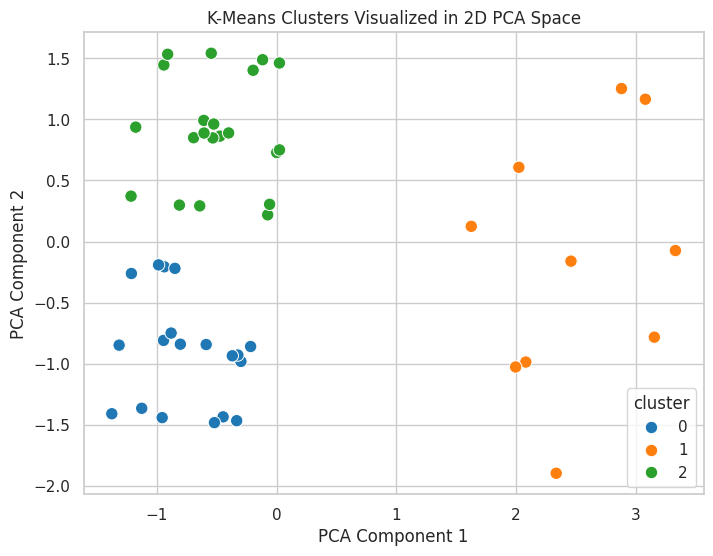

In [5]:
# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_clusters['pca1'] = X_pca[:,0]
df_clusters['pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', n_colors=k)
sns.scatterplot(data=df_clusters, x='pca1', y='pca2', hue='cluster', palette=palette, s=80)
plt.title('K-Means Clusters Visualized in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='cluster')
plt.show()


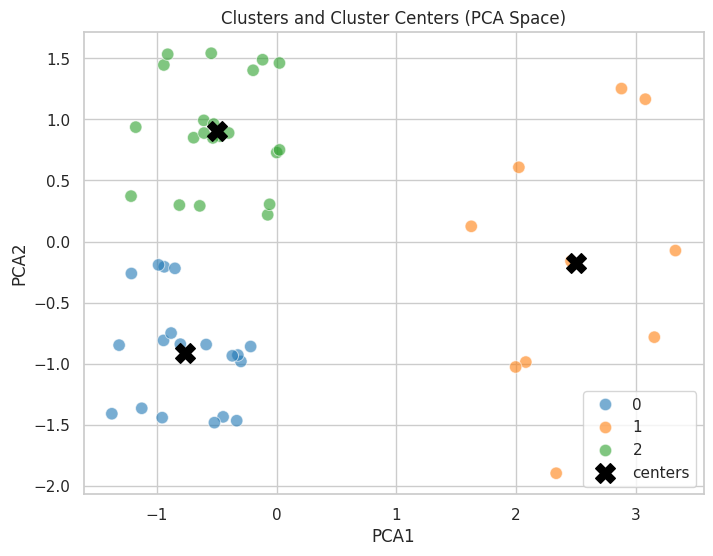

In [6]:
centers_scaled = kmeans.cluster_centers_
centers_pca = pca.transform(centers_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clusters, x='pca1', y='pca2', hue='cluster', palette=palette, s=80, alpha=0.6)
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200, c='black', label='centers')
plt.title('Clusters and Cluster Centers (PCA Space)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [7]:
if len(set(cluster_labels)) > 1:
    sil_score = silhouette_score(X_scaled, cluster_labels)
    print(f"Silhouette score for k={k}: {sil_score:.3f}")
else:
    print('Only one cluster found — silhouette score not defined.')


Silhouette score for k=3: 0.495


In [8]:
cluster_summary = df_clusters.groupby('cluster').agg(
    count=('cluster','size'),
    mean_area=('Area','mean'),
    median_area=('Area','median'),
    mean_price=('Price','mean')
).reset_index()
cluster_summary


,cluster,count,mean_area,median_area,mean_price
0,0,19,100.631692,96.793962,182987.399205
1,1,10,261.378977,249.965956,509078.865822
2,2,21,101.656233,101.185324,196612.000266
